In [ ]:
!apt-get update
!apt-get install -y octave liboctave-dev
!pip install datasets huggingface_hub vllm math-verify openpyxl

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,741 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,003 kB]
Get:13 https://ppa.launchpadcontent.net/

In [ ]:
from google.colab import drive

# Ejecuta la función de montaje
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!which octave
!octave --eval "disp(2 + 2)"

/usr/bin/octave
octave: X11 DISPLAY environment variable not set
octave: disabling GUI features
4


# Definiciones de clases

In [ ]:
import time
import os
# Configurar las variables de entorno para controlar el registro de vLLM
#os.environ["VLLM_CONFIGURE_LOGGING"] = "0"
#os.environ["VLLM_LOGGING_LEVEL"] = "ERROR"
#os.environ["VLLM_USE_PROGRESS_BAR"] = "false"
import logging
from huggingface_hub import snapshot_download
from vllm import LLM, SamplingParams


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger(__name__)

# Configurar las variables de entorno para controlar el registro de vLLM
#os.environ["VLLM_CONFIGURE_LOGGING"] = "0"
#os.environ["VLLM_LOGGING_LEVEL"] = "ERROR"


class VLLMGenerator:
    def __init__(
        self,
        model_name: str,
        download: bool = False,
        temperature: float = 0.0,
        top_p: float = 1.0,
        max_tokens: int = 1024,
        log_prompts: bool = False
    ):
        self.model_source = model_name
        self.log_prompts = log_prompts

        if download:
            folder_name = model_name.split('/')[-1]
            logger.info("Downloading model %s to ./%s...", model_name, folder_name)
            self.model_source = snapshot_download(
                repo_id=model_name,
                local_dir=folder_name
            )
            logger.info("Model downloaded to: %s", self.model_source)

        load_start = time.time()
        self.llm = LLM(
            model=self.model_source,
            trust_remote_code=True,
            task="generate"
        )
        logger.info("Model loaded in %.2f seconds", time.time() - load_start)

        self.sampling_params = SamplingParams(
            temperature=temperature,
            top_p=top_p,
            max_tokens=max_tokens
        )
        logger.info("Sampling parameters set: %s", self.sampling_params)

    def generate(self, prompts: list) -> list:
        start = time.time()
        outputs = self.llm.generate(prompts, self.sampling_params)
        logger.info("Generation completed in %.2f seconds", time.time() - start)
        return [out.outputs[0].text for out in outputs]

    def chat(self, messages: list[dict], debug: bool = None) -> str:
        prompt = ""
        for message in messages:
            role = message["role"].strip().lower()
            content = message["content"].strip()
            if role == "user":
                prompt += "<|user|>\n" + content + "\n"
            elif role == "assistant":
                prompt += "<|assistant|>\n" + content + "\n"
        prompt += "<|assistant|>\n"

        should_log = debug if debug is not None else self.log_prompts
        if should_log:
            print("📤 Prompt enviado al modelo:\n" + "-"*40 + f"\n{prompt}\n" + "-"*40)

        response = self.generate([prompt])
        return response[0].strip() if response else ""

    def batch_chat(self, conversations: list[list[dict]], debug: bool = False) -> list[str]:
        prompts = []
        for i, messages in enumerate(conversations):
            prompt = ""
            for message in messages:
                role = message["role"].strip().lower()
                content = message["content"].strip()
                if role == "user":
                    prompt += "<|user|>\n" + content + "\n"
                elif role == "assistant":
                    prompt += "<|assistant|>\n" + content + "\n"
            prompt += "<|assistant|>\n"
            prompts.append(prompt)

            if debug or self.log_prompts:
                print(f"\n📤 Prompt #{i + 1}:\n" + "-"*40 + f"\n{prompt}\n" + "-"*40)

        results = self.generate(prompts)
        return [r.strip() for r in results]


INFO 06-04 14:23:22 [__init__.py:243] Automatically detected platform cuda.


In [ ]:
from typing import Dict, List

class ModelRegistry:
    """
    Registry of supported Hugging Face models for vLLMGenerator.

    Contains a fixed list of model identifiers and their metadata.
    """
    # Mapping from model key to huggingface repo id
    MODEL_REPOS: Dict[str, str] = {
        "llama3-8b-instruct": "nreHieW/Llama-3.1-8B-Instruct",
        "deepseek-math-7b": "deepseek-ai/deepseek-math-7b-instruct",
        "qwen2-7b": "Qwen/Qwen2-7B",
        "qwen2-7b-instruct": "Qwen/Qwen2-7B-Instruct",
        "qwen2-math-7b-instruct": "Qwen/Qwen2-Math-7B-Instruct",
        "mistral-7b-instruct": "mistralai/Mistral-7B-Instruct-v0.3",
        "mathstral-7b": "mistralai/Mathstral-7B-v0.1",
        "deepseek-coder-7b": "deepseek-ai/deepseek-coder-7b-instruct-v1.5",
    }

    # Additional details for each model
    MODEL_DETAILS: Dict[str, Dict[str, str]] = {
        "llama3-8b-instruct": {
            "description": "LLaMA-3 8B instruct-tuned model",
            "parameters": "8 billion",
            "context_length": "8192 tokens",
            "suitable_for": "Instruction following tasks with improved reasoning",
        },
        "deepseek-math-7b": {
            "description": "DeepSeek Math 7B instruct model",
            "parameters": "7 billion",
            "context_length": "4096 tokens",
            "suitable_for": "Mathematical problem solving and proofs",
        },
        "qwen2-7b": {
            "description": "Qwen 2 7B base model",
            "parameters": "7 billion",
            "context_length": "4096 tokens",
            "suitable_for": "General purpose text generation",
        },
        "qwen2-7b-instruct": {
            "description": "Qwen 2 7B instruct-tuned model",
            "parameters": "7 billion",
            "context_length": "4096 tokens",
            "suitable_for": "Instruction-based tasks and chat",
        },
        "qwen2-math-7b-instruct": {
            "description": "Qwen 2 Math 7B instruct model",
            "parameters": "7 billion",
            "context_length": "4096 tokens",
            "suitable_for": "Mathematical reasoning and code generation",
        },
        "mistral-7b-instruct": {
            "description": "Mistral 7B Instruct v0.3",
            "parameters": "7 billion",
            "context_length": "8192 tokens",
            "suitable_for": "Instruction following with long context",
        },
        "mathstral-7b": {
            "description": "Mathstral 7B",
            "parameters": "7 billion",
            "context_length": "8192 tokens",
            "suitable_for": "Mathematics-specific tasks",
        },
        "deepseek-coder-7b": {
            "description": "DeepSeek Coder 7B instruct model",
            "parameters": "7 billion",
            "context_length": "4096 tokens",
            "suitable_for": "Code generation and debugging",
        },
    }

    @classmethod
    def get_supported_models(cls) -> List[str]:
        """Return list of supported model keys."""
        return list(cls.MODEL_REPOS.keys())

    @classmethod
    def get_model_repo(cls, model_key: str) -> str:
        """Given a model key, return the HF repository identifier."""
        return cls.MODEL_REPOS[model_key]

    @classmethod
    def get_model_details(cls, model_key: str) -> Dict[str, str]:
        """Return metadata for a given model key."""
        return cls.MODEL_DETAILS.get(model_key, {})

    @classmethod
    def validate_model_key(cls, model_key: str) -> bool:
        """Check if a model key is registered."""
        return model_key in cls.MODEL_REPOS

    @classmethod
    def as_list_of_repos(cls) -> List[str]:
        """Return list of HF repo strings for all supported models."""
        return list(cls.MODEL_REPOS.values())

In [ ]:
import subprocess
import tempfile
import os
import shutil

class OctaveExecutionError(Exception): pass
class OctaveTimeoutError(Exception): pass

class OctaveCodeExecutor:
    def __init__(self, timeout: int = 10, octave_cmd: str = 'octave', max_output_size: int = 10000):
        self.timeout = timeout
        self.octave_cmd = octave_cmd
        self.max_output_size = max_output_size

        # ✅ Verificar que el binario esté disponible
        if shutil.which(self.octave_cmd) is None:
            raise FileNotFoundError(
                f"❌ El binario '{self.octave_cmd}' no se encontró en el sistema.\n"
                f"🛠 Asegúrate de instalar Octave con:\n"
                f"!apt-get update && apt-get install -y octave"
            )

    def _write_temp_file(self, code: str) -> str:
        with tempfile.NamedTemporaryFile(mode='w', suffix='.m', delete=False) as f:
            f.write(code)
            return f.name

    def execute_with_timeout(self, code: str) -> tuple[str | None, str | None]:
        file_path = self._write_temp_file(code)
        try:
            result = subprocess.run(
                [self.octave_cmd, "--quiet", "--no-gui", "--eval", f"run('{file_path}')"],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                timeout=self.timeout,
                text=True,
                check=False
            )
            stdout = result.stdout[:self.max_output_size].strip()
            stderr = result.stderr.strip()
            return stdout, stderr if stderr else None
        except subprocess.TimeoutExpired:
            raise OctaveTimeoutError("⏱️ Tiempo de ejecución excedido para el código Octave.")
        finally:
            os.remove(file_path)


In [ ]:
from datasets import load_from_disk, Dataset
import os
from pathlib import Path
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import torch.nn.functional as F
from pymilvus import MilvusClient

# ─── Definir clase Retriever usando Milvus Lite ───────────────
class MilvusRetriever:
    def __init__(self, df, encoder, db_path, collection_name):
        self.df = df.reset_index(drop=True)
        self.encoder = encoder
        self.client = MilvusClient(uri=db_path)
        self.collection_name = collection_name

        if collection_name not in self.client.list_collections():
            self.client.create_collection(
                collection_name,
                dimension=384,
                consistency_level="Eventually",
                auto_id=True
            )
            self._index_data()
        else:
            print(f"✅ Milvus collection '{collection_name}' ya existe.")

    def _index_data(self):
        print("📥 Indexando vectores en Milvus...")
        vectors = np.stack(self.df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))).astype(np.float32)
        entities = [
            {"question": row["question"], "octave_code": row["octave_code"], "vector": vec}
            for row, vec in zip(self.df.to_dict(orient="records"), vectors)
        ]
        self.client.insert(self.collection_name, data=entities, progress_bar=True)
        print("✅ Indexación completada.")

    def retrieve(self, query, top_k=3):
        q_emb = self.encoder.encode([query], convert_to_numpy=True)
        q_emb = F.normalize(torch.tensor(q_emb), p=2, dim=1).numpy().astype(np.float32)

        results = self.client.search(
            self.collection_name,
            data=q_emb,
            output_fields=["question", "octave_code"],
            limit=top_k + 1,
            consistency_level="Eventually"
        )

        seen = set()
        retrieved = []
        for hit in results[0]:
            q_text = hit.entity["question"].strip()
            if q_text == query.strip():
                continue
            if q_text in seen:
                continue
            seen.add(q_text)
            retrieved.append(f"Problem: {q_text}\nCode: {hit.entity['octave_code']}")
            if len(retrieved) == top_k:
                break

        return "\n".join(retrieved)

    def list_all_problems(self):
        return self.df["question"].drop_duplicates().tolist()

In [ ]:
import pandas as pd
import random
from collections import defaultdict

class FewShotRetriever:
    def __init__(self, csv_path: str):
        """
        Inicializa el retriever cargando el .csv y clasificando ejemplos por problem_type.

        Args:
            csv_path (str): Ruta al archivo CSV con las columnas 'question', 'octave_code' y 'problem_type'
        """
        self.examples_by_type = defaultdict(list)
        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            problem_type = row.get("problem_type", "Unknown")
            question = row.get("question", "").strip()
            code = row.get("octave_code", "").strip()

            if question and code:
                self.examples_by_type[problem_type].append((question, code))

        print(f"✅ Indexados ejemplos por tipo de problema: {len(self.examples_by_type)} categorías")

    def retrieve(self, question_type: str, k: int = 3) -> list[str]:
        """
        Recupera k ejemplos del mismo tipo de problema.

        Args:
            question_type (str): Tipo de problema del cual recuperar ejemplos.
            k (int): Número de ejemplos a recuperar.

        Returns:
            list[str]: Lista de strings con problema + código
        """
        candidates = self.examples_by_type.get(question_type, [])
        if not candidates:
            return ""

        sampled = random.sample(candidates, min(k, len(candidates)))
        retrieved =  [f"Problem: {q}\nCode: {c}" for q, c in sampled]


        return "\n".join(retrieved)


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import pickle
import re

class BertMultiTaskClassifier(nn.Module):
    def __init__(self, dropout, num_problem_types, num_question_types):
        super(BertMultiTaskClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.classifier_problem = nn.Linear(768, num_problem_types)
        self.classifier_question = nn.Linear(768, num_question_types)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        pooled_output = outputs[1]
        x = self.dropout(pooled_output)
        x = self.activation(x)
        logits_problem = self.classifier_problem(x)
        logits_question = self.classifier_question(x)
        return logits_problem, logits_question

import re
import pickle

def preprocess_function(example, tokenizer, seq_len):
    text = example["problem"].lower()
    # Conservar operadores y puntuación matemática relevante
    text = re.sub(r"[^\w\d\s\+\-\*/=^√%.,()]", " ", text)
    # Normalizar repeticiones de 'x' largas
    text = re.sub(r'\b[x]{2,}\b', 'x', text)
    text = re.sub(' +', ' ', text)

    tokens = tokenizer(text, padding="max_length", max_length=seq_len, truncation=True)
    return tokens

# Funciones para guardar y cargar objetos con pickle
def save_file(name, obj):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

def load_file(name):
    return pickle.load(open(name, "rb"))

class MultiTaskInferencePipeline:
    def __init__(self, model_path, encoder_problem_path, encoder_question_path, dropout=0.5):
        self.preprocess_function = preprocess_function  # Guardamos la función

        with open(encoder_problem_path, "rb") as f:
            self.le_problem = pickle.load(f)
        with open(encoder_question_path, "rb") as f:
            self.le_question = pickle.load(f)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
        self.model = BertMultiTaskClassifier(dropout, len(self.le_problem.classes_), len(self.le_question.classes_))
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict(self, text):
        # Preprocesar usando la misma función que durante el entrenamiento
        example = {"problem": text}
        encoded = self.preprocess_function(example, self.tokenizer, seq_len=512)

        input_ids = torch.tensor(encoded["input_ids"]).unsqueeze(0).to(self.device)
        attention_mask = torch.tensor(encoded["attention_mask"]).unsqueeze(0).to(self.device)

        with torch.no_grad():
            logits_problem, logits_question = self.model(input_ids, attention_mask)
            pred_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()[0]
            pred_question = torch.argmax(logits_question, dim=1).cpu().numpy()[0]

        label_problem = self.le_problem.inverse_transform([pred_problem])[0]
        label_question = self.le_question.inverse_transform([pred_question])[0]

        return {
            "problem_type": label_problem,
            "question_type": label_question
        }

In [ ]:
import logging
from typing import Dict, List, Any
from abc import ABC, abstractmethod
import re
import json
import time
import torch.nn.functional as F
import time
from pymilvus import MilvusClient

logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

pattern_true = re.compile(r"\btrue\b", re.IGNORECASE)
pattern_false = re.compile(r"\bfalse\b", re.IGNORECASE)

class ConversationalPromptStrategy(ABC):
    """
    Clase base abstracta para estrategias conversacionales.

    Cada subclase debe implementar un flujo completo de conversación
    con el modelo, incluyendo resolubilidad, extracción de características
    (si aplica) y generación de código.
    """

    @abstractmethod
    def run_conversation(self, row: dict, generator) -> dict:
        """
        Ejecuta una conversación completa con el modelo para un problema dado.

        Args:
            row (dict): Una fila del dataset (de un CSV).
            generator: Instancia del generador (e.g., VLLMGenerator).

        Returns:
            dict: Un diccionario con al menos:
                - 'resolvability_response'
                - 'is_octave_resolvable' (bool)
                - 'problem_features' (opcional)
                - 'model_output' (código o razonamiento final)
        """
        pass





class ZeroShotConversationalStrategy(ConversationalPromptStrategy):
    def run_conversation(self, row: dict, generator) -> dict:
        start_time = time.time()  # ⏱️ Inicio del temporizador

        question = str(row.get("question", "")).strip()
        if not question:
            return {"inference_time": 0.0}

        messages = []

        # Paso 1: Introducción
        messages.append({"role": "user", "content": f"Here is a math problem:\n\n{question}"})
        messages.append({"role": "assistant", "content": "OK, I've received the problem."})

        # Paso 2: Resolvabilidad
        messages.append({
            "role": "user",
            "content": (
                "Determine if the math problem can be solved programmatically using GNU Octave."
                "Answer with 'True' or 'False' and justify your choice."
            )
        })
        resolvability_response = generator.chat(messages)
        messages.append({"role": "assistant", "content": resolvability_response})

        if re.search(pattern_true, resolvability_response) and not re.search(pattern_false, resolvability_response.split("true")[0]):
            is_octave_resolvable = True
        elif re.search(pattern_false, resolvability_response):
            is_octave_resolvable = False
        else:
            is_octave_resolvable = None  # incierto o malformado

        # Paso 3: Características del problema (si es resoluble)
        problem_features = None
        if is_octave_resolvable:
            messages.append({
                "role": "user",
                "content": (
                    "Analyze the problem and extract its key data and the following characteristics:\n"
                    "'given_data', 'unknowns', 'constraints','applicable methods','If a unit of measurement is used, specify which one'.\n\n"
                )
            })
            problem_features = generator.chat(messages)
            messages.append({"role": "assistant", "content": problem_features})

        # Paso 4: Generación de código
        if is_octave_resolvable:
            messages.append({
                "role": "user",
                "content": (
                    "Generate only a GNU Octave script that, when executed, prints the numeric answer."
                )
            })
        else:
            messages.append({
                "role": "user",
                "content": (
                   "Provide the solution to the math problem in the most suitable way."
                )
            })

        model_output = generator.chat(messages)
        messages.append({"role": "assistant", "content": model_output})

        end_time = time.time()  # ⏱️ Fin del temporizador
        inference_duration = end_time - start_time

        return {
            "resolvability_prompt": messages[0]["content"],
            "resolvability_response": resolvability_response,
            "is_octave_resolvable": is_octave_resolvable,
            "problem_features": problem_features,
            "prompt": json.dumps(messages),
            "model_output": model_output,
            "inference_time": inference_duration  # ⏱️ Tiempo total en segundos
        }

class ChainOfThoughtConversationalStrategy(ConversationalPromptStrategy):
    def run_conversation(self, row: dict, generator) -> dict:
        start_time = time.time()  # ⏱️ Inicio del temporizador

        question = str(row.get("question", "")).strip()
        rationale = str(row.get("rationale", "")).strip()
        if not question:
            return {"inference_time": 0.0}

        messages = []

        # Paso 1: Introducción
        if rationale:
            messages.append({"role": "user", "content": f"Here is a math problem:\n\n{question}.\nRationale: {rationale}\n"})
        else:
            messages.append({"role": "user", "content": f"Here is a math problem:\n\n{question}."})
        messages.append({"role": "assistant", "content": "OK, I've received the problem."})

        # Paso 2: Resolvabilidad
        messages.append({
            "role": "user",
            "content": (
                "Determine if the math problem can be solved programmatically using GNU Octave."
                "Answer with 'True' or 'False' and justify your choice."
            )
        })
        resolvability_response = generator.chat(messages)
        messages.append({"role": "assistant", "content": resolvability_response})

        if re.search(pattern_true, resolvability_response) and not re.search(pattern_false, resolvability_response.split("true")[0]):
            is_octave_resolvable = True
        elif re.search(pattern_false, resolvability_response):
            is_octave_resolvable = False
        else:
            is_octave_resolvable = None  # incierto o malformado

        # Paso 3: Características del problema (si es resoluble)
        problem_features = None
        if is_octave_resolvable:
            messages.append({
                "role": "user",
                "content": (
                    "Analyze the problem and extract its key data and the following characteristics:\n"
                    "'given_data', 'unknowns', 'constraints','applicable methods','If a unit of measurement is used, specify which one'.\n\n"
                )
            })
            problem_features = generator.chat(messages)
            messages.append({"role": "assistant", "content": problem_features})

        # Paso 4: Generación de código
        if is_octave_resolvable:
            messages.append({
                "role": "user",
                "content": (
                    "Generate only a GNU Octave script that, when executed, prints the numeric answer."
                )
            })
        else:
            messages.append({
                "role": "user",
                "content": (
                   "Provide the solution to the math problem in the most suitable way."
                )
            })

        model_output = generator.chat(messages)
        messages.append({"role": "assistant", "content": model_output})

        end_time = time.time()  # ⏱️ Fin del temporizador
        inference_duration = end_time - start_time

        return {
            "resolvability_prompt": messages[0]["content"],
            "resolvability_response": resolvability_response,
            "is_octave_resolvable": is_octave_resolvable,
            "problem_features": problem_features,
            "prompt": json.dumps(messages),
            "model_output": model_output,
            "inference_time": inference_duration  # ⏱️ Tiempo total en segundos
        }

class APEConversationalStrategy(ConversationalPromptStrategy):
    def __init__(self, rounds: int):
        """
        variants: Lista de variantes de instrucciones (plantillas) para que el modelo elija.
        """
        self.rounds = rounds

    def run_conversation(self, row: dict, generator) -> dict:
        start_time = time.time()  # ⏱️ Inicio del temporizador

        question = str(row.get("question", "")).strip()
        if not question:
            return {"inference_time": 0.0}

        messages = []

        # Paso 1: Introducción
        messages.append({"role": "user", "content": f"Here is a math problem:\n\n{question}"})
        messages.append({"role": "assistant", "content": "OK, I've received the problem."})

        # Paso 2: Resolvabilidad
        messages.append({
            "role": "user",
            "content": (
                "Determine if the math problem can be solved programmatically using GNU Octave."
                "Answer with 'True' or 'False' and justify your choice."
            )
        })
        resolvability_response = generator.chat(messages)
        messages.append({"role": "assistant", "content": resolvability_response})

        if re.search(pattern_true, resolvability_response) and not re.search(pattern_false, resolvability_response.split("true")[0]):
            is_octave_resolvable = True
        elif re.search(pattern_false, resolvability_response):
            is_octave_resolvable = False
        else:
            is_octave_resolvable = None  # incierto o malformado

        # Paso 3: Características del problema (si es resoluble)
        problem_features = None
        if is_octave_resolvable:
            messages.append({
                "role": "user",
                "content": (
                    "Analyze the problem and extract its key data and the following characteristics:\n"
                    "'given_data', 'unknowns', 'constraints','applicable methods','If a unit of measurement is used, specify which one'.\n\n"
                )
            })
            problem_features = generator.chat(messages)
            messages.append({"role": "assistant", "content": problem_features})

        # Paso 4: Generación de código
        if is_octave_resolvable:
            messages.append({
                "role": "user",
                "content": (
                    "Generate only a GNU Octave script that, when executed, prints the numeric answer."
                )
            })
        else:
            messages.append({
                "role": "user",
                "content": (
                   "Provide the solution to the math problem in the most suitable way."
                )
            })

        pattern_first = re.compile(r"\First\b", re.IGNORECASE)
        pattern_second = re.compile(r"\bSecond\b", re.IGNORECASE)

        best_variant = generator.construct_prompt(messages)
        count = 1
        while count < self.rounds:

            optimization_prompt = ( "I will provide you with a prompt that is given as input to a model whose task is to solve math problems by generating the corresponding code.\n"
                                    "Your goal is to review and improve it to make it clearer, more precise, and more effective.\n"
                                    "1. Analyze the original prompt and identify any ambiguities or missing information.\n"
                                    "2. Reformulate it to increase clarity, specificity, and include any instructions that will help the downstream model generate correct and efficient code.\n"
                                    "3. Return only the improved prompt, without any additional commentary.\n"
                                    "Here is the original prompt (between triple quotes):\n"
                                    "\"\"\"\n"
                                    f"{best_variant}"
                                    "\"\"\"\n")
            new_prompt = generator.generate([optimization_prompt])

            selection_prompt = (
            "You are given two prompt variants for solving a math problem.\n "
            "Based on the problem and context, decide which variant is the most suitable to solve it.\n"
            "Respond with 'First' if it is the first, or 'Second' if it is the second:\n"
            f"Prompt 1: {best_variant}\n"
            f"Prompt 2: {new_prompt}"
            )
            optimal = generator.generate([optimization_prompt])


            if re.search(pattern_second,optimal):
                best_variant = new_prompt
            count += 1

        model_output = generator.chat(best_variant)
        messages.append({"role": "assistant", "content": model_output})

        end_time = time.time()  # ⏱️ Fin del temporizador
        inference_duration = end_time - start_time

        return {
            "resolvability_prompt": messages[0]["content"],
            "resolvability_response": resolvability_response,
            "is_octave_resolvable": is_octave_resolvable,
            "problem_features": problem_features,
            "prompt": json.dumps(messages),
            "model_output": model_output,
            "inference_time": inference_duration  # ⏱️ Tiempo total en segundos
        }


class RAGConversationalStrategy(ConversationalPromptStrategy):
    def __init__(self, retriever):
        """
        retriever: clase con método retrieve(text: str) -> str
        """
        self.retriever = retriever

    def run_conversation(self, row: dict, generator) -> dict:
        start_time = time.time()  # ⏱️ Inicio del temporizador

        question = str(row.get("question", "")).strip()
        if not question:
            return {"inference_time": 0.0}

        messages = []

        # Paso 1: Introducción
        messages.append({"role": "user", "content": f"Here is a math problem:\n\n{question}"})
        messages.append({"role": "assistant", "content": "OK, I've received the problem."})

        # Paso 2: Resolvabilidad
        messages.append({
            "role": "user",
            "content": (
                "Determine if the math problem can be solved programmatically using GNU Octave."
                " Answer with 'True' or 'False' and justify your choice."
            )
        })
        resolvability_response = generator.chat(messages)
        messages.append({"role": "assistant", "content": resolvability_response})

        if re.search(pattern_true, resolvability_response) and not re.search(pattern_false, resolvability_response.split("true")[0]):
            is_octave_resolvable = True
        elif re.search(pattern_false, resolvability_response):
            is_octave_resolvable = False
        else:
            is_octave_resolvable = None

        # Paso 3: Características del problema (si es resoluble)
        problem_features = None
        if is_octave_resolvable:
            messages.append({
                "role": "user",
                "content": (
                    "Analyze the problem and extract its key data and the following characteristics:\n"
                    "'given_data', 'unknowns', 'constraints','applicable methods','If a unit of measurement is used, specify which one'.\n\n"
                )
            })
            problem_features = generator.chat(messages)
            messages.append({"role": "assistant", "content": problem_features})

        # Paso 4: Generación de código (con o sin RAG)
        if is_octave_resolvable:
            retrieved_context = self.retriever.retrieve(question)

            messages.append({
                "role": "user",
                "content": (
                    f"You are given related examples:\n{retrieved_context}\n\n"
                    f"Problem features: {problem_features}\n\n"
                    f"Problem: {question}\n\n"
                    "Generate only a GNU Octave script that, when executed, prints the numeric answer."
                )
            })
        else:
            messages.append({
                "role": "user",
                "content": (
                    f"Problem: {question}\n\n"
                    "Provide the solution to the math problem in the most suitable way."
                )
            })

        model_output = generator.chat(messages)
        messages.append({"role": "assistant", "content": model_output})

        end_time = time.time()  # ⏱️ Fin del temporizador
        inference_duration = end_time - start_time

        return {
            "resolvability_prompt": messages[0]["content"],
            "resolvability_response": resolvability_response,
            "is_octave_resolvable": is_octave_resolvable,
            "problem_features": problem_features,
            "prompt": json.dumps(messages),
            "model_output": model_output,
            "inference_time": inference_duration
        }

class FewShotConversationalStrategy(ConversationalPromptStrategy):
    def __init__(self, retriever, classifier=None, k=3):
        self.retriever = retriever  # debe tener método retrieve(k, problem_type=None)
        self.classifier = classifier  # puede ser None
        self.k = k

    def run_conversation(self, row: dict, generator) -> dict:
        start_time = time.time()  # ⏱️ Inicio del temporizador

        question = str(row.get("question", "")).strip()
        if not question:
            return {"inference_time": 0.0}

        messages = []

        # Paso 1: Introducción
        messages.append({"role": "user", "content": f"Here is a math problem:\n\n{question}"})
        messages.append({"role": "assistant", "content": "OK, I've received the problem."})

        # Paso 2: Resolvabilidad
        messages.append({
            "role": "user",
            "content": (
                "Determine if the math problem can be solved programmatically using GNU Octave."
                " Answer with 'True' or 'False' and justify your choice."
            )
        })
        resolvability_response = generator.chat(messages)
        messages.append({"role": "assistant", "content": resolvability_response})

        if re.search(pattern_true, resolvability_response) and not re.search(pattern_false, resolvability_response.split("true")[0]):
            is_octave_resolvable = True
        elif re.search(pattern_false, resolvability_response):
            is_octave_resolvable = False
        else:
            is_octave_resolvable = None

        # Paso 3: Características del problema (si es resoluble)
        problem_features = None
        if is_octave_resolvable:
            messages.append({
                "role": "user",
                "content": (
                    "Analyze the problem and extract its key data and the following characteristics:\n"
                    "'given_data', 'unknowns', 'constraints','applicable methods','If a unit of measurement is used, specify which one'.\n\n"
                )
            })
            problem_features = generator.chat(messages)
            messages.append({"role": "assistant", "content": problem_features})

               # Paso 4: Generación de código (con o sin RAG)
        if is_octave_resolvable:
            question_type = None
            if self.classifier:
                try:
                    preds = self.classifier.predict(question)
                    question_type = preds.get("problem_type", None)
                except:
                    question_type = None
            if question_type:
                    retrieved_context = self.retriever.retrieve(question_type = question_type, k=self.k)
            if len(retrieved_context) > 0:
                messages.append({
                    "role": "user",
                    "content": (
                        f"You are given related examples:\n{retrieved_context}\n\n"
                        f"Problem features: {problem_features}\n\n"
                        f"Problem: {question}\n\n"
                        "Generate only a GNU Octave script that, when executed, prints the numeric answer."
                    )
                })
            else:
                    messages.append({
                    "role": "user",
                    "content": (
                        f"Problem features: {problem_features}\n\n"
                        f"Problem: {question}\n\n"
                        "Generate only a GNU Octave script that, when executed, prints the numeric answer."
                    )
                })
        else:
            messages.append({
                "role": "user",
                "content": (
                    f"Problem: {question}\n\n"
                    "Provide the solution to the math problem in the most suitable way."
                )
            })


        model_output = generator.chat(messages)
        messages.append({"role": "assistant", "content": model_output})

        end_time = time.time()  # ⏱️ Fin del temporizador
        inference_duration = end_time - start_time

        return {
            "resolvability_prompt": messages[0]["content"],
            "resolvability_response": resolvability_response,
            "is_octave_resolvable": is_octave_resolvable,
            "problem_features": problem_features,
            "prompt": json.dumps(messages),
            "model_output": model_output,
            "inference_time": inference_duration
        }

In [ ]:
# Rutas fijas en Google Drive para cada dataset
DATASET_PATHS = {
    "aqua": "/content/drive/MyDrive/tesis/datasets/AQUA/test.json",
    "gsm8k": "/content/drive/MyDrive/tesis/datasets/GSM-8K/test.jsonl",
    "math_data": "/content/drive/MyDrive/tesis/datasets/MATH/math_data.jsonl",
    "math_shuffled": "/content/drive/MyDrive/tesis/datasets/MATH/shuffled_math.jsonl",
    "mmlu": "/content/drive/MyDrive/tesis/datasets/MMLU/MMLU_test.jsonl",
}

In [ ]:
import json
import os
import re
from typing import Dict, List, Optional

import pandas as pd


class DatasetCSVBuilder:
    """
    Transforma datasets JSON/JSONL a CSV estandarizado para el pipeline experimental,
    con soporte para procesar solo los primeros `max_items` registros si se desea.
    """

    def __init__(self, dataset_paths: Dict[str, str]):
        self.dataset_paths = dataset_paths
        self.unit_pattern = re.compile(r'[$€£%]|m\b|cm\b|kg\b|km\b')
        self.choice_pattern = re.compile(r'^([A-Za-z])\)(.*)$')

        # Columnas adicionales necesarias para el pipeline experimental completo
        self.experiment_columns = [
            "strategy",
            "model",
            "dataset",
            "resolvability_prompt",
            "resolvability_response",
            "is_octave_resolvable",
            "problem_features",
            "prompt",
            "model_output",
            "inference_time",
            "octave_code",
            "execution_output",
            "execution_error",
            "is_correct",
        ]

    # --------------------------------------------------------------------- #
    # API pública
    # --------------------------------------------------------------------- #
    def create_dataset(
        self,
        key: str, max_items: Optional[int] = None,   # ← NUEVO parámetro opcional
    ) -> pd.DataFrame:
        """
        Lee el dataset indicado por `key`, procesa hasta `max_items`
        registros (o todos si es None) y guarda el CSV resultante.

        Args:
            key: clave que identifica el dataset en `dataset_paths`.
            max_items: n.º máximo de registros a conservar (None = todos).

        Returns:
            pd.DataFrame con los datos transformados.
        """
        path = self.dataset_paths[key]
        records = self._load_records(path, max_items=max_items)
        df = pd.DataFrame(records)
        df = self._transform_dataframe(key, df)
        df = self._add_experiment_columns(df, dataset_name=key)
        self._save_as_csv(df, path, max_items=max_items)
        return df

    # --------------------------------------------------------------------- #
    # Funciones internas
    # --------------------------------------------------------------------- #
    def _load_records(
        self,
        path: str,
        *,
        max_items: Optional[int] = None,
    ) -> List[dict]:
        """
        Devuelve una lista de diccionarios cargados desde un .json o .jsonl.
        Si `max_items` está definido, corta la lista a ese tamaño.
        """
        data = []
        with open(path, "r", encoding="utf-8") as f:
            try:
                if path.endswith(".jsonl"):
                    for line in f:
                        if line.strip():
                            data.append(json.loads(line.strip()))
                            if max_items and len(data) >= max_items:
                                break
                else:  # .json o similar
                    content = json.load(f)
                    if isinstance(content, list):
                        data.extend(content[:max_items] if max_items else content)
                    else:
                        data.append(content)
            except json.JSONDecodeError as e:
                print(f"Error al leer {path}: {e}")

        return data

    def _transform_dataframe(self, name: str, df: pd.DataFrame) -> pd.DataFrame:
        # … (sin cambios: la lógica específica de cada dataset)
        if name == "aqua":
            df = df.rename(columns={"correct": "answer"})
            if "options" in df.columns:
                df["options"] = df["options"].apply(
                    lambda x: ';'.join(x) if isinstance(x, list) else x
                )
                df["answer_alternative"] = df.apply(self._map_if_unit, axis=1)

        elif name == "gsm8k":
            if "answer" in df.columns:
                df[["rationale", "answer"]] = df["answer"].str.split("####", expand=True)

        elif name in ("math_data", "math_shuffled"):
            df = df.rename(columns={"problem": "question", "solution": "rationale"})
            if "rationale" in df.columns:
                df["answer"] = df["rationale"].str.extract(r'\\boxed\{([^}]*)\}')
                df["rationale"] = df["rationale"].str.replace(
                    r'\\boxed\{([^}]*)\}', '', regex=True
                )

        elif name == "mmlu":
            df = df.rename(columns={"Question": "question"})
            options_cols = [col for col in df.columns if col.startswith("Option")]
            if options_cols:
                df["options"] = df[options_cols].apply(
                    lambda row: ';'.join(row.values.astype(str)), axis=1
                )

        return df

    def _add_experiment_columns(self, df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
        for col in self.experiment_columns:
            if col not in df.columns:
                df[col] = dataset_name if col == "dataset" else None
        return df

    def _map_if_unit(self, row):
        letter = row.get("answer")
        options = row.get("options", "")
        if not isinstance(options, str):
            return None

        options = [p.strip() for p in options.split(';') if p.strip()]
        mapping = {}
        for opt in options:
            if self.choice_pattern.match(opt):
                key, val = opt.split(')', 1)
                mapping[key] = val.strip()

        if not mapping and len(options) >= 4:
            mapping = {'A': options[0], 'B': options[1], 'C': options[2], 'D': options[3]}

        value = mapping.get(letter, None)
        return (
            self.unit_pattern.sub('', value).strip()
            if value and self.unit_pattern.search(value)
            else value
        )

    def _save_as_csv(
        self,
        df: pd.DataFrame,
        original_path: str,
        *,
        max_items: Optional[int] = None,
    ):
        """
        Guarda el CSV con un sufijo que indica si es un recorte parcial.
        Ej.: foo_experiment.csv  ó  foo_experiment_100.csv
        """
        base_dir = os.path.dirname(original_path)
        base_name = os.path.splitext(os.path.basename(original_path))[0]
        suffix = f"_experiment_{max_items}" if max_items else "_experiment"
        output_path = os.path.join(base_dir, f"{base_name}{suffix}.csv")
        df.to_csv(output_path, index=False)
        print(f"✅ CSV experimental guardado en: {output_path}")


In [ ]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
import re
import logging
from math_verify import parse, verify

logger = logging.getLogger("octave_validator")

_CODE_RE = re.compile(r"```(?:octave|m)?[\s\r\n]*(.*?)```", re.DOTALL | re.I)
_NUM_RE = re.compile(r"[-+]?\d*\.?\d+(?:[eE][+-]?\d+)?[ij]?", re.I)

def extract_octave_code(text: str) -> str:
    m = _CODE_RE.search(str(text))
    return m.group(1).strip() if m else str(text).strip()

def extract_numbers(text: str) -> set[str]:
    return {m.group(0).lower() for m in _NUM_RE.finditer(str(text))}

def validate_octave_code_for_strategy(
    csv_path: str,
    executor,
    batch_size: int = 8,
    overwrite: bool = False,
    output_dir: str = None
) -> str:
    """
    Valida el código Octave generado por una estrategia (única) en un CSV.

    Args:
        csv_path: Ruta al CSV de entrada.
        executor: Instancia de OctaveCodeExecutor.
        batch_size: Tamaño de lote.
        overwrite: Si True, sobrescribe resultados previos.
        output_dir: Si se proporciona, guarda copia del CSV actualizado.
    """
    df = pd.read_csv(csv_path)

    code_col = "model_output"
    answer_col = "answer"
    exec_col = "execution_output"
    error_col = "execution_error"
    correct_col = "is_correct"
    extracted_col = "octave_code"

    for col in [exec_col, error_col, correct_col, extracted_col]:
        if col not in df.columns:
            df[col] = None

    for i in tqdm(range(len(df)), desc="Validating Octave"):
        if not overwrite and pd.notna(df.at[i, correct_col]):
            continue

        raw_code = df.at[i, code_col]
        gold = str(df.at[i, answer_col]).strip()
        if not isinstance(raw_code, str) or not raw_code.strip():
            continue

        code = extract_octave_code(raw_code)
        df.at[i, extracted_col] = code

        try:
            stdout, stderr = executor.execute_with_timeout(code)
            df.at[i, exec_col] = stdout
            df.at[i, error_col] = stderr

            correct = False
            if stderr is None and stdout:
                try:
                    correct = verify(parse(gold), parse(stdout))
                except Exception:
                    correct = False

                if not correct:
                    out_nums = extract_numbers(stdout)
                    gold_nums = extract_numbers(gold)
                    correct = bool(out_nums) and out_nums.issubset(gold_nums)

            df.at[i, correct_col] = correct

        except Exception as e:
            df.at[i, exec_col] = None
            df.at[i, error_col] = str(e)
            df.at[i, correct_col] = False

    df.to_csv(csv_path, index=False)

    if output_dir:
        fecha = datetime.now().strftime("%Y%m%d")
        outfile = Path(output_dir) / f"{fecha}_{Path(csv_path).stem}_validated.csv"
        df.to_csv(outfile, index=False)
        logger.info(f"📁 Validación guardada en: {outfile}")
        return str(outfile)

    return str(csv_path)


In [ ]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import logging
import re
from math_verify import parse, verify
import textwrap
from datetime import datetime
from IPython.display import display, Markdown


logger = logging.getLogger("strategy_runner")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

def run_multiple_conversational_strategies_over_csv(
    csv_path: str,
    strategies: dict[str, ConversationalPromptStrategy],
    generator,
    start_idx: int = 0,
    end_idx: int = None,
    overwrite: bool = False,
    output_dir: str = None
):
    """
    Ejecuta múltiples estrategias conversacionales sobre un CSV.

    Args:
        csv_path (str): Ruta del CSV original.
        strategies (dict): Claves son nombres, valores son instancias de estrategias.
        generator: Generador compatible con .chat()
        start_idx, end_idx: Rango de filas a procesar.
        overwrite: Recalcular si ya hay datos.
        output_dir: Ruta para guardar versión final enriquecida.
    """
    df = pd.read_csv(csv_path)
    total = len(df)
    end_idx = min(end_idx if end_idx is not None else total, total)

    logger.info(f"🎯 Ejecutando múltiples estrategias (una a la vez): {list(strategies.keys())}")
    logger.info(f"Filas a procesar: {start_idx} → {end_idx - 1}")

    for strategy_key, strategy in strategies.items():
        logger.info(f"\n⚙️ Estrategia activa: '{strategy_key}'")

        for i in tqdm(range(start_idx, end_idx), desc=f"{strategy_key}"):
            row = df.iloc[i].to_dict()

            # Salta si ya hay resultado y no se quiere sobrescribir
            if not overwrite and "model_output" in df.columns and pd.notna(df.at[i, "model_output"]):
                continue

            try:
                result = strategy.run_conversation(row, generator)
            except Exception as e:
                logger.error(f"❌ Error en fila {i} con estrategia {strategy_key}: {e}")
                continue

            if not isinstance(result, dict):
                continue

            for key, value in result.items():
                if key not in df.columns:
                    df[key] = None
                df.at[i, key] = value

            # Guardado intermedio tras cada fila
            df.to_csv(csv_path, index=False)

    logger.info("✅ Todas las estrategias completadas.")

    if output_dir:
        fecha = datetime.now().strftime("%Y%m%d")
        outfile = Path(output_dir) / f"{fecha}_{Path(csv_path).stem}_multi.csv"
        df.to_csv(outfile, index=False)
        logger.info(f"📁 CSV actualizado guardado en: {outfile}")

def review_incorrect_but_executed(
    csv_path: str,
    max_items: int = 10,
    start_idx: int = 0
):
    """
    Muestra ejemplos ejecutados sin errores pero marcados como incorrectos,
    para revisión manual. Funciona con archivos que usan columnas sin sufijo de estrategia.

    Args:
        csv_path (str): Ruta al archivo CSV validado.
        max_items (int): Máximo de ejemplos a mostrar.
        start_idx (int): Índice inicial para comenzar la revisión.
    """
    df = pd.read_csv(csv_path)

    candidates = df[
        (df["is_correct"] == False) &
        (df["execution_error"].isna()) &
        (df["execution_output"].notna())
    ]

    candidates = candidates.iloc[start_idx:start_idx + max_items]

    for idx, row in candidates.iterrows():
        display(Markdown(f"""
### 🔍 Ejemplo {idx}

**📌 Pregunta:**
```
{row['question']}
```

**📤 Código generado:**
```octave
{row['octave_code']}
```

**📥 Output:**
```
{row['execution_output']}
```

**✅ Respuesta esperada:**
```
{row['answer']}
```

**🛑 Error:**
{row['execution_error'] if pd.notna(row['execution_error']) else "❌ Ninguno"}

**✔️ ¿Es correcta manualmente?** *(modificar directamente en el CSV si corresponde)*
"""))

    print(f"\nMostrando {len(candidates)} casos desde el índice {start_idx}.")

def run_conversational_strategy_over_csv_batch(
    csv_path: str,
    strategy,
    generator,
    start_idx: int = 0,
    end_idx: int = None,
    batch_size: int = 8,
    overwrite: bool = False,
    output_dir: str = None
):
    """
    Ejecuta una estrategia conversacional fila a fila con llamadas a `run_conversation(...)`.

    Args:
        csv_path (str): Ruta al archivo CSV.
        strategy: Estrategia con `run_conversation(row, generator)`.
        generator: Instancia de VLLMGenerator.
        start_idx (int): Índice inicial.
        end_idx (int): Índice final (exclusive).
        batch_size (int): Tamaño del lote.
        overwrite (bool): Si False, salta ejemplos ya procesados.
        output_dir (str): Carpeta para guardar una copia del CSV.
    """
    path = Path(csv_path)
    df = pd.read_csv(path)
    total = len(df)
    end_idx = min(end_idx if end_idx is not None else total, total)
    start_idx = max(start_idx, 0)

    for batch_start in tqdm(range(start_idx, end_idx, batch_size), desc="Batches"):
        batch_end = min(batch_start + batch_size, end_idx)
        rows = df.iloc[batch_start:batch_end]

        for i, row in rows.iterrows():
            idx = row.name

            if not overwrite and "model_output" in df.columns and pd.notna(df.at[idx, "model_output"]):
                continue

            try:
                result = strategy.run_conversation(row.to_dict(), generator)

                for k, v in result.items():
                    if k not in df.columns:
                        df[k] = None
                    df.at[idx, k] = v

            except Exception as e:
                logger.error(f"Error procesando fila {idx}: {e}")
                continue

        df.to_csv(path, index=False)

    if output_dir:
        fecha = datetime.now().strftime("%Y%m%d")
        outfile = Path(output_dir) / f"{fecha}_{path.stem}_batch.csv"
        df.to_csv(outfile, index=False)
        logger.info(f"📁 CSV actualizado guardado en: {outfile}")


def review_incorrect_but_executed_interactively(
    csv_path: str,
    max_items: int = 10,
    start_idx: int = 0
):
    """
    Revisa manualmente ejemplos con ejecución válida pero marcados como incorrectos.
    Permite corregir interactivamente el campo de veracidad.

    Args:
        csv_path (str): Ruta al archivo CSV con resultados validados.
        max_items (int): Número máximo de ejemplos a mostrar.
        start_idx (int): Índice inicial para comenzar la revisión.
    """
    df = pd.read_csv(csv_path)

    exec_col = "execution_output"
    error_col = "execution_error"
    correct_col = "is_correct"
    code_col = "octave_code"

    candidates = df[
        (df[correct_col] == False) &
        (df[error_col].isna()) &
        (df[exec_col].notna())
    ]

    candidates = candidates.iloc[start_idx:start_idx + max_items]

    if candidates.empty:
        print("🎉 No hay ejemplos para revisar.")
        return

    print(f"🔍 Revisión interactiva de ejemplos desde índice {start_idx} (máx {max_items}). Usa 'y' para corregir, 'n' para omitir, 'q' para salir.\n")

    for idx, row in candidates.iterrows():
        print("=" * 100)
        print(f"Fila: {idx}")
        print("\n📌 QUESTION:")
        print(textwrap.fill(str(row['question']), width=100))

        print("\n💻 OCTAVE CODE:")
        print(row[code_col] or "⛔ No hay código")

        print("\n📤 OUTPUT:")
        print(row[exec_col] or "⛔ Sin salida")

        print("\n🌟 ANSWER:")
        print(row['answer'] or "⛔ Sin respuesta esperada")

        ans = input("\n✅ ¿Marcar como correcta? [y/n/q]: ").strip().lower()
        if ans == "y":
            df.at[idx, correct_col] = True
            print("✔️ Marcada como correcta.\n")
        elif ans == "q":
            print("⏹️ Revisión interrumpida.\n")
            break
        else:
            print("❌ Se mantiene como incorrecta.\n")

    df.to_csv(csv_path, index=False)
    print(f"📁 Archivo actualizado: {csv_path}")




In [ ]:
MODEL_KEY = "mathstral-7b"
# Instanciar generador
generator = VLLMGenerator(
    model_name= ModelRegistry.get_model_repo(MODEL_KEY),
    download=True,
    temperature=0.3,
    top_p=0.95,
    max_tokens=1024,
    log_prompts=False
)

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

INFO 06-04 14:24:13 [__init__.py:31] Available plugins for group vllm.general_plugins:
INFO 06-04 14:24:13 [__init__.py:33] - lora_filesystem_resolver -> vllm.plugins.lora_resolvers.filesystem_resolver:register_filesystem_resolver
INFO 06-04 14:24:13 [__init__.py:36] All plugins in this group will be loaded. Set `VLLM_PLUGINS` to control which plugins to load.
INFO 06-04 14:24:13 [config.py:3131] Downcasting torch.float32 to torch.float16.
INFO 06-04 14:24:29 [config.py:2118] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 06-04 14:24:30 [core.py:438] Waiting for init message from front-end.
INFO 06-04 14:24:30 [core.py:65] Initializing a V1 LLM engine (v0.9.0.1) with config: model='/content/Mathstral-7B-v0.1', speculative_config=None, tokenizer='/content/Mathstral-7B-v0.1', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=32768, download_dir=None

Loading safetensors checkpoint shards:   0% Completed | 0/6 [00:00<?, ?it/s]


INFO 06-04 14:26:48 [default_loader.py:280] Loading weights took 135.56 seconds
INFO 06-04 14:26:48 [gpu_model_runner.py:1549] Model loading took 13.5084 GiB and 136.005993 seconds
INFO 06-04 14:27:01 [backends.py:459] Using cache directory: /root/.cache/vllm/torch_compile_cache/bf466918bd/rank_0_0 for vLLM's torch.compile
INFO 06-04 14:27:01 [backends.py:469] Dynamo bytecode transform time: 12.72 s


[rank0]:W0604 14:27:03.163000 10794 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


INFO 06-04 14:27:06 [backends.py:158] Cache the graph of shape None for later use
INFO 06-04 14:27:37 [backends.py:170] Compiling a graph for general shape takes 35.57 s
INFO 06-04 14:27:56 [monitor.py:33] torch.compile takes 48.30 s in total
INFO 06-04 14:27:58 [kv_cache_utils.py:637] GPU KV cache size: 42,400 tokens
INFO 06-04 14:27:58 [kv_cache_utils.py:640] Maximum concurrency for 32,768 tokens per request: 1.29x
INFO 06-04 14:28:41 [gpu_model_runner.py:1933] Graph capturing finished in 44 secs, took 0.51 GiB
INFO 06-04 14:28:41 [core.py:167] init engine (profile, create kv cache, warmup model) took 112.95 seconds


In [ ]:
import logging
from pathlib import Path
from datetime import datetime


# Configuración
DATASET_KEY = "gsm8k"
STRATEGY_NAME = "zero_shot"


RAW_DATASET_PATHS = {
    "gsm8k": "/content/drive/MyDrive/tesis/datasets/GSM-8K/test.jsonl",
    "math_data": "/content/drive/MyDrive/tesis/datasets/MATH/math_data.jsonl",
    "math_shuffled": "/content/drive/MyDrive/tesis/datasets/MATH/shuffled_math.jsonl",
}

OUTPUT_DIR = "/content/drive/MyDrive/tesis/experimentos_finales"

# Inicialización de logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("pipeline")

# 1. Crear CSV del experimento
builder = DatasetCSVBuilder(dataset_paths=RAW_DATASET_PATHS)
df = builder.create_dataset(DATASET_KEY)
df["model"] = MODEL_KEY
df["strategy"] = STRATEGY_NAME
df["dataset"] = DATASET_KEY

# Guardar CSV inicial
fecha = datetime.now().strftime("%Y%m%d")
file_name = f"{fecha}_{DATASET_KEY}_{MODEL_KEY}_{STRATEGY_NAME}.csv".replace("/", "-")
csv_path = Path(OUTPUT_DIR) / MODEL_KEY / file_name
csv_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(csv_path, index=False)


# Seleccionar estrategia
strategy = ZeroShotConversationalStrategy()

# Ejecutar pipeline conversacional por lotes
run_conversational_strategy_over_csv_batch(
    csv_path=str(csv_path),
    strategy=strategy,
    generator=generator,
    start_idx=0,
    end_idx=100,
    batch_size=16,
    overwrite=True
)

# Validación con Octave
executor = OctaveCodeExecutor(timeout=10)

validate_octave_code_for_strategy(
    csv_path=str(csv_path),
    executor=executor,
    batch_size=8,
    overwrite=True,
    output_dir=OUTPUT_DIR
)

# Revisión manual de ejemplos incorrectos pero sin errores de ejecución
review_incorrect_but_executed_interactively(
    csv_path=csv_path,
    max_items=100,
    start_idx=0
)

logger.info("Pipeline completado exitosamente.")


✅ CSV experimental guardado en: /content/drive/MyDrive/tesis/datasets/AQUA/test_experiment.csv


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

<ipython-input-7-faf8d2afb784>:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Here is a math problem:

A car is being driven, in a straight line and at a uniform speed, towards the base of a vertical tower. The top of the tower is observed from the car and, in the process, it takes 10 minutes for the angle of elevation to change from 45° to 60°. After how much more time will this car reach the base of the tower?' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, k] = v
<ipython-input-7-faf8d2afb784>:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True. GNU Octave is a high-level language, primarily intended for numerical computations. It provides a wide range of functions for mathematical operations, including trigonometric functions, which are necessary to solve t

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batches:  14%|█▍        | 1/7 [05:41<34:10, 341.73s/it]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batches:  29%|██▊       | 2/7 [10:22<25:28, 305.67s/it]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batches:  43%|████▎     | 3/7 [16:21<22:01, 330.32s/it]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batches:  57%|█████▋    | 4/7 [22:51<17:41, 353.92s/it]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batches:  71%|███████▏  | 5/7 [28:55<11:55, 357.55s/it]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batches:  86%|████████▌ | 6/7 [34:06<05:41, 341.56s/it]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Validating Octave:   0%|          | 0/254 [00:00<?, ?it/s]<ipython-input-6-498985aa9865>:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '% Define the variables
t1 = 10; % Time taken for angle to change from 45° to 60°
theta1 = 45 * pi / 180; % Initial angle in radians
theta2 = 60 * pi / 180; % Final angle in radians

% Calculate the distance from the car to the base of the tower
d = t1 * (theta2 - theta1) / (theta2 - theta1);

% Calculate the time taken to reach the base of the tower
t2 = d / (theta2 - theta1);

% Display the result
disp(['The car will reach the base of the tower in ', num2str(t2), ' minutes.'])' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, extracted_col] = code
<ipython-input-6-498985aa9865>:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'The car 

🔍 Revisión interactiva de ejemplos desde índice 0 (máx 100). Usa 'y' para corregir, 'n' para omitir, 'q' para salir.

Fila: 0

📌 QUESTION:
A car is being driven, in a straight line and at a uniform speed, towards the base of a vertical
tower. The top of the tower is observed from the car and, in the process, it takes 10 minutes for
the angle of elevation to change from 45° to 60°. After how much more time will this car reach the
base of the tower?

💻 OCTAVE CODE:
% Define the variables
t1 = 10; % Time taken for angle to change from 45° to 60°
theta1 = 45 * pi / 180; % Initial angle in radians
theta2 = 60 * pi / 180; % Final angle in radians

% Calculate the distance from the car to the base of the tower
d = t1 * (theta2 - theta1) / (theta2 - theta1);

% Calculate the time taken to reach the base of the tower
t2 = d / (theta2 - theta1);

% Display the result
disp(['The car will reach the base of the tower in ', num2str(t2), ' minutes.'])

📤 OUTPUT:
The car will reach the base of the tow

# Guardar a excell resultados

In [ ]:
!pip install openpyxl


In [ ]:
import pandas as pd

# Ruta al archivo CSV que deseas convertir
csv_path = "/content/drive/MyDrive/tesis/experimentos_finales/mathstral-7b/20250603_gsm8k_mathstral-7b_zero_shot.csv"

# Ruta destino para el archivo Excel
excel_path = csv_path.replace(".csv", ".xlsx")

# Leer y guardar como Excel
df = pd.read_csv(csv_path)
df.to_excel(excel_path, index=False)

print(f"✅ Archivo convertido y guardado como: {excel_path}")


✅ Archivo convertido y guardado como: /content/drive/MyDrive/tesis/experimentos_finales/mathstral-7b/20250603_gsm8k_mathstral-7b_zero_shot.xlsx


In [ ]:
import os
import pandas as pd
from IPython.display import display

# Ruta base
BASE_PATH = "/content/drive/MyDrive/tesis/experimentos_finales"

# Lista para guardar resúmenes
summaries = []

# Buscar todos los archivos .csv
for root, _, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)
            try:
                df = pd.read_csv(csv_path)

                # Extraer valores y manejar casos faltantes
                model = df.get("model", ["unknown"])[0]
                strategy = df.get("strategy", ["unknown"])[0]
                dataset = df.get("dataset", ["unknown"])[0]
                total = len(df)
                correct = df["is_correct"].sum() if "is_correct" in df.columns else None
                incorrect = (df["is_correct"] == False).sum() if "is_correct" in df.columns else None
                accuracy = correct / total if correct is not None else None
                resolvable = df["is_octave_resolvable"].sum() if "is_octave_resolvable" in df.columns else None
                avg_time = df["inference_time"].mean() if "inference_time" in df.columns else None

                summaries.append({
                    "Model": model,
                    "Strategy": strategy,
                    "Dataset": dataset,
                    "Total Examples": total,
                    "Resolvable (True)": resolvable,
                    "Correct": correct,
                    "Incorrect": incorrect,
                    "Accuracy": round(accuracy, 3) if accuracy is not None else None,
                    "Avg. Inference Time (s)": round(avg_time, 2) if avg_time is not None else None,
                    "Path": csv_path
                })

            except Exception as e:
                print(f"❌ Error procesando {csv_path}: {e}")

# Convertir a DataFrame resumen y mostrar
summary_df = pd.DataFrame(summaries).sort_values(by="Accuracy", ascending=False)
display(summary_df)


Model   Strategy        Dataset  Total Examples  \
5             mathstral-7b  zero_shot          gsm8k            1319   
4             mathstral-7b  zero_shot          gsm8k            1319   
3             mathstral-7b  zero_shot          gsm8k            1319   
14            mathstral-7b  zero_shot          gsm8k            1319   
15            mathstral-7b  zero_shot          gsm8k            1319   
13            mathstral-7b  zero_shot          gsm8k            1319   
17            mathstral-7b  zero_shot  math_shuffled            5000   
7             mathstral-7b  zero_shot  math_shuffled            5000   
16            mathstral-7b  zero_shot      math_data            5000   
6             mathstral-7b  zero_shot      math_data            5000   
0   qwen2-math-7b-instruct  zero_shot          gsm8k            1319   
2         deepseek-math-7b  zero_shot          gsm8k            1319   
1   qwen2-math-7b-instruct  zero_shot          gsm8k            1319   
9             mathstral-7b  zero_shot           aqua             254   
10  qwen2-math-7b-instruct  zero_shot          gsm8k            1319   
11  qwen2-math-7b-instruct  zero_shot          gsm8k            1319   
12        deepseek-math-7b  zero_shot          gsm8k            1319   
18            mathstral-7b  zero_shot           aqua             254   
19      llama3-8b-instruct  zero_shot          gsm8k            1319   
8   qwen2-math-7b-instruct  zero_shot          gsm8k              17   

    Resolvable (True)  Correct  Incorrect  Accuracy  Avg. Inference Time (s)  \
5                99.0     77.0       23.0     0.058                    23.27   
4                99.0     77.0       23.0     0.058                      NaN   
3                99.0     77.0       23.0     0.058                      NaN   
14               99.0     77.0       23.0     0.058                      NaN   
15               99.0     77.0       23.0     0.058                    23.27   
13               99.0     77.0       23.0     0.058                      NaN   
17               96.0     28.0       72.0     0.006                    19.69   
7                96.0     28.0       72.0     0.006                    19.69   
16               93.0     27.0       73.0     0.005                    19.30   
6                93.0     25.0       75.0     0.005                    19.30   
0                 0.0      0.0        0.0     0.000                      NaN   
2                 0.0      0.0        0.0     0.000                      NaN   
1                 0.0      0.0        0.0     0.000                      NaN   
9                98.0      0.0      100.0     0.000                    21.18   
10                0.0      0.0        0.0     0.000                      NaN   
11                0.0      0.0        0.0     0.000                      NaN   
12                0.0      0.0        0.0     0.000                      NaN   
18               98.0      0.0      100.0     0.000                    21.18   
19               14.0      0.0        0.0     0.000                      NaN   
8                 NaN      NaN        NaN       NaN                      NaN   

                                                 Path  
5   /content/drive/MyDrive/tesis/experimentos_fina...  
4   /content/drive/MyDrive/tesis/experimentos_fina...  
3   /content/drive/MyDrive/tesis/experimentos_fina...  
14  /content/drive/MyDrive/tesis/experimentos_fina...  
15  /content/drive/MyDrive/tesis/experimentos_fina...  
13  /content/drive/MyDrive/tesis/experimentos_fina...  
17  /content/drive/MyDrive/tesis/experimentos_fina...  
7   /content/drive/MyDrive/tesis/experimentos_fina...  
16  /content/drive/MyDrive/tesis/experimentos_fina...  
6   /content/drive/MyDrive/tesis/experimentos_fina...  
0   /content/drive/MyDrive/tesis/experimentos_fina...  
2   /content/drive/MyDrive/tesis/experimentos_fina...  
1   /content/drive/MyDrive/tesis/experimentos_fina...  
9   /content/drive/MyDrive/tesis/experiment

In [ ]:
! pip install ace_tools

✅ Resumen guardado en: /content/drive/MyDrive/tesis/experimentos_finales/resumen_experimentos.csv


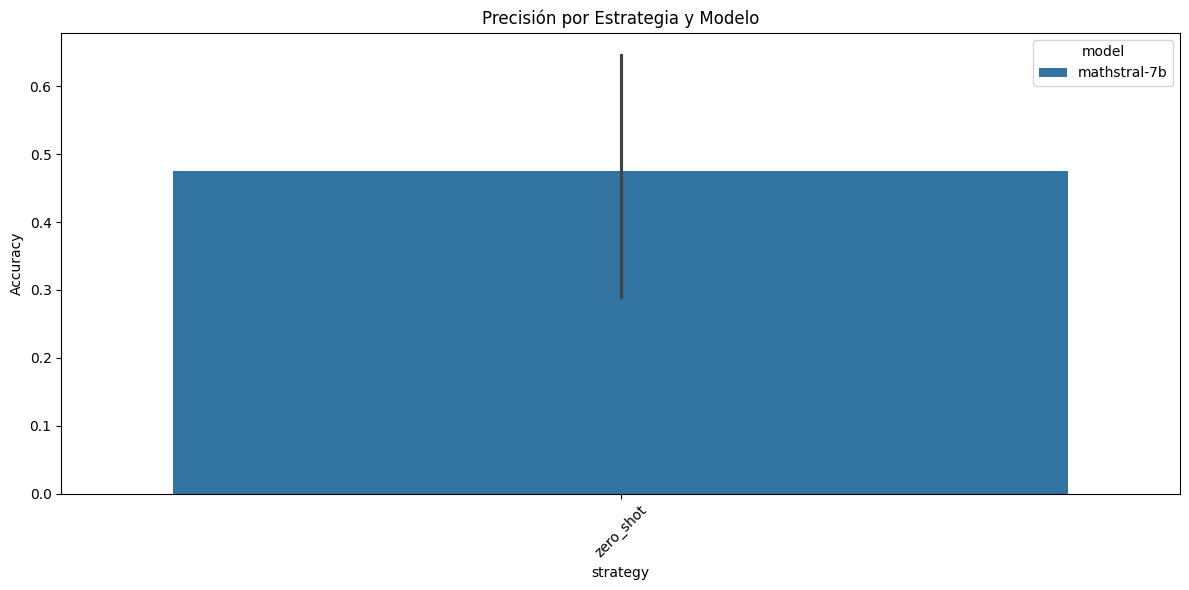

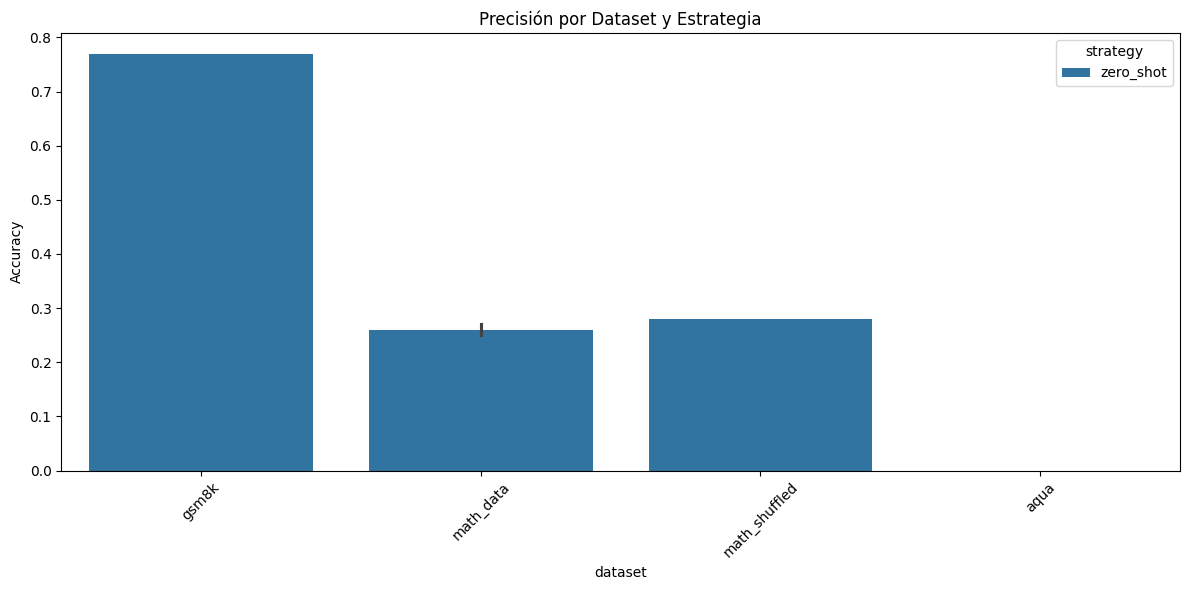

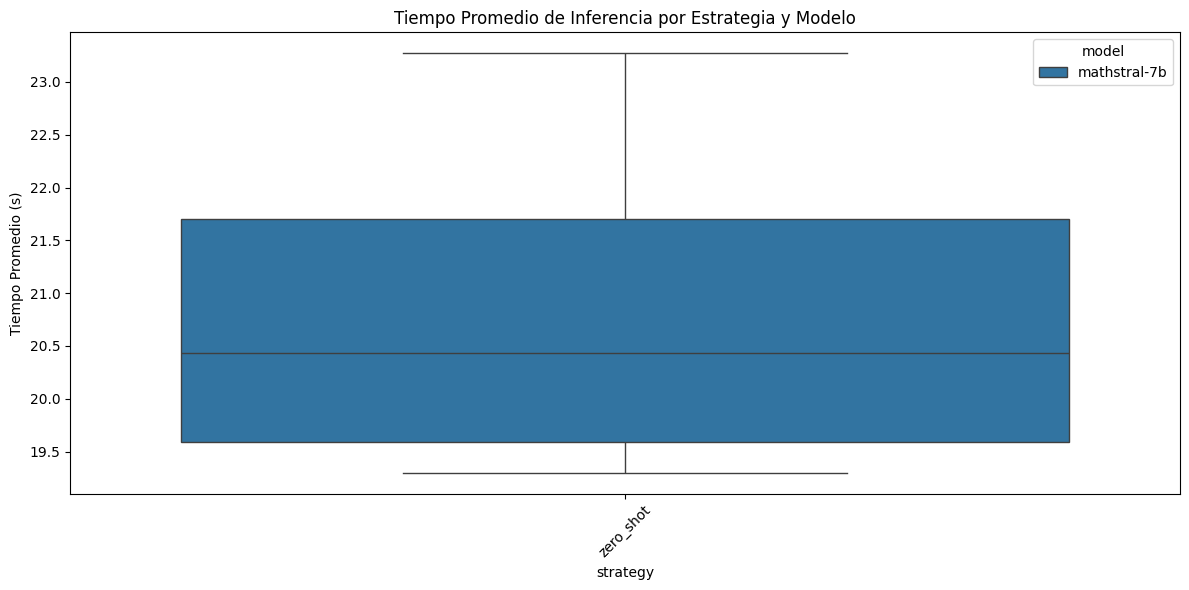

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# ─── 1. Configurar ruta base de resultados ───────────────────────────────
BASE_PATH = "/content/drive/MyDrive/tesis/experimentos_finales"

# ─── 2. Recolectar métricas de todos los archivos CSV ────────────────────
summary = []
for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".csv"):
            path = os.path.join(root, file)
            try:
                df = pd.read_csv(path)
                if "is_correct" not in df.columns:
                    continue
                summary.append({
                    "model": df.get("model", ["unknown"])[0],
                    "strategy": df.get("strategy", ["unknown"])[0],
                    "dataset": df.get("dataset", ["unknown"])[0],
                    "total": len(df),
                    "correct": df["is_correct"].sum(),
                    "incorrect": (df["is_correct"] == False).sum(),
                    "accuracy": df["is_correct"].mean(),
                    "resolvable": df.get("is_octave_resolvable", pd.Series([None]*len(df))).sum(),
                    "inference_time_avg": df.get("inference_time", pd.Series([None]*len(df))).mean(),
                    "path": path
                })
            except Exception as e:
                print(f"⚠️ Error al procesar {path}: {e}")

summary_df = pd.DataFrame(summary)

# ─── 3. Guardar resumen en CSV ───────────────────────────────────────────
resumen_path = os.path.join(BASE_PATH, "resumen_experimentos.csv")
summary_df.to_csv(resumen_path, index=False)
print(f"✅ Resumen guardado en: {resumen_path}")

# ─── 4. Visualizaciones ──────────────────────────────────────────────────
# Eliminar filas con datos faltantes
valid_df = summary_df.dropna(subset=["strategy", "model", "accuracy", "dataset"])

# Gráfico: Precisión por estrategia y modelo
plt.figure(figsize=(12, 6))
sns.barplot(data=valid_df, x="strategy", y="accuracy", hue="model")
plt.title("Precisión por Estrategia y Modelo")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico: Precisión por dataset y estrategia
plt.figure(figsize=(12, 6))
sns.barplot(data=valid_df, x="dataset", y="accuracy", hue="strategy")
plt.title("Precisión por Dataset y Estrategia")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico: Tiempo promedio de inferencia por estrategia
plt.figure(figsize=(12, 6))
sns.boxplot(data=valid_df, x="strategy", y="inference_time_avg", hue="model")
plt.title("Tiempo Promedio de Inferencia por Estrategia y Modelo")
plt.ylabel("Tiempo Promedio (s)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
